In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [0]:
#deleta osarquivos anteriores para a nova criação
dbutils.fs.rm('dbfs:/user/hive/warehouse/dbequals.db/', True)

True

In [0]:
%sql
--cria o banco de dados
create database if not exists dbequals

In [0]:
# **********************************************************************************
# Cria as tabelas e insere no banco dbequals

clientes = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/Clientes.csv')

clientes.write.saveAsTable("dbequals.clientes")

# **********************************************************************************

segmentos = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/Segmentos.csv')

segmentos.write.saveAsTable("dbequals.segmentos")

# **********************************************************************************

moedas = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/Moedas.csv')

moedas.write.saveAsTable("dbequals.moedas")

# **********************************************************************************

PrecoTransacao = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/PrecoTransacao.csv')

PrecoTransacao = PrecoTransacao.withColumnRenamed('INICIO FAIXA', 'INICIOFAIXA')
PrecoTransacao = PrecoTransacao.withColumnRenamed('FIM FAIXA', 'FIMFAIXA')

PrecoTransacao.write.saveAsTable("dbequals.PrecoTransacao")

# **********************************************************************************

PesquisaSatisfacao = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/PesquisaSatisfacao.csv')

PesquisaSatisfacao.write.saveAsTable("dbequals.PesquisaSatisfacao")

# **********************************************************************************

vendas = spark.read.format('csv') \
.options(header='true', inferSchema=True) \
.option("sep",";") \
.option("encoding", "UTF-8") \
.load('/FileStore/tables/equals/Dados/Vendas.csv')

vendas.write.saveAsTable("dbequals.vendas")

# **********************************************************************************

In [0]:
%sql

-- **********************************************************************************
-- Cria as temp views
create or replace temporary view clientes as (
  select
    IDCLIENTE,
    NOMEFANTASIA,
    FLSITUACAO,
    SGUF,
    IDSEGMENTACAO,
    IDMOEDA
  from
    dbequals.clientes
);
-- **********************************************************************************
create or replace temporary view segmentos as (
  select
    IDSEGMENTACAO,
    TIPO,
    SEGMENTO,
    ifnull(CATEGORIA, ' ') as CATEGORIA
  from
    dbequals.segmentos
  );
-- **********************************************************************************
create or replace temporary view moedas as (
  select
    IDMOEDA,
    MOEDA,
    MES,
    cast(replace(COTACAO, ',', '.') as float) as COTACAO
  from
    dbequals.moedas
);
-- **********************************************************************************
create or replace temporary view PrecoTransacao as (
  select
    INICIOFAIXA,
    ifnull(FIMFAIXA, 9999999999) as FIMFAIXA,
    cast(replace(PRECO, ',', '.') as float) as PRECO 
  from
    dbequals.PrecoTransacao
);
-- **********************************************************************************
create or replace temporary view PesquisaSatisfacao as (
  select
    *
  from
    dbequals.PesquisaSatisfacao
);
-- **********************************************************************************
create or replace temporary view vendas as (
  select
    IDCLIENTE,
    MES,
    cast(replace(VLVENDA, ',', '.') as float) as VLVENDA,
    QTVENDA,
    QTPARCELAS,
    QTESTABEL
  from
    dbequals.Vendas
);

In [0]:
%sql
--query dos joins necessários para a analise
create or replace temporary view faturamento as (
  with join_1 as (
    select
      A.*,
      B.PRECO,
      C.NOMEFANTASIA,
      C.IDMOEDA,
      C.IDSEGMENTACAO,
      C.SGUF,
      C.FLSITUACAO
    from
      vendas A
      left join PrecoTransacao B
      on A.QTVENDA between B.INICIOFAIXA
      and B.FIMFAIXA
      left join clientes C
      on A.IDCLIENTE = C.IDCLIENTE
  ),
  join_2 as (
    select
    A.*,
    B.COTACAO,
    B.MOEDA,
    C.NOTA as NOTASATISFACAO,
    D.SEGMENTO,
    D.CATEGORIA
  from
    join_1 A
    left join moedas B
    on A.MES = B.MES and A.IDMOEDA = B.IDMOEDA
    left join PesquisaSatisfacao C
    on A.IDCLIENTE = C.IDCLIENTE and A.MES = C.MES
    left join Segmentos D
    on A.IDSEGMENTACAO = D.IDSEGMENTACAO
  )
  select
    IDCLIENTE,
    NOMEFANTASIA,
    MES,
    VLVENDA,
    QTVENDA,
    QTPARCELAS,
    QTESTABEL,
    PRECO,
    SGUF,
    FLSITUACAO,
    COTACAO,
    MOEDA,
    NOTASATISFACAO,
    case
      when NOTASATISFACAO < 7 then 'Detratoras'
      when NOTASATISFACAO in (7,8) then 'Neutras'
      when NOTASATISFACAO >= 9 then 'Promotoras'
      else 'NotAplicv'
    end CLASSIFICACAO,
    SEGMENTO,
    case
      when CATEGORIA = ' ' then 'Sem Categoria'
      else CATEGORIA
    end CATEGORIA,
    round((QTVENDA * PRECO * COTACAO), 2) as FATURAMENTO
  from
    join_2
)

In [0]:
%sql
-- view de faturamento agrupado por mês
create or replace temporary view faturamentoagrup as (
  select
    MES,
    round(sum(VLVENDA),2) as VLVENDA,
    round(sum(QTVENDA),2) as QTVENDA,
    round(sum(QTPARCELAS),2) as QTPARCELAS,
    round(sum(QTESTABEL),2) as QTESTABEL,
    round(sum(FATURAMENTO),2) as FATURAMENTO,
    count(distinct IDCLIENTE) as QTCLIENTES,
    round(AVG(FATURAMENTO),2) as MEDFATCLIENTE,
    round(AVG(NOTASATISFACAO),2) as MEDSATISFACAO,
    round(sum(FATURAMENTO) / sum(QTESTABEL),2) as MEDFATESTAB
  from
    faturamento
  group by
    MES
  order by
    MES
)

In [0]:
%sql
-- view de faturamento agrupado por mês e segmento
create or replace temporary view faturamentoagrupseg as (
  select
    MES,
    SEGMENTO,
    round(sum(VLVENDA),2) as VLVENDA,
    round(sum(QTVENDA),2) as QTVENDA,
    round(sum(QTPARCELAS),2) as QTPARCELAS,
    round(sum(QTESTABEL),2) as QTESTABEL,
    round(sum(FATURAMENTO),2) as FATURAMENTO,
    count(distinct IDCLIENTE) as QTCLIENTES,
    round(AVG(FATURAMENTO),2) as MEDFATCLIENTE,
    round(AVG(NOTASATISFACAO),2) as MEDSATISFACAO,
    round(sum(FATURAMENTO) / sum(QTESTABEL),2) as MEDFATESTAB
  from
    faturamento
  group by
    MES,
    SEGMENTO
  order by
    MES,
    MEDSATISFACAO desc
)

In [0]:
%sql
-- view de faturamento agrupado por mês, segmento e por classificação
create or replace temporary view faturamentoagrupsegclass as (
  select
    MES,
    SEGMENTO,
    CLASSIFICACAO,
    round(sum(VLVENDA),2) as VLVENDA,
    round(sum(QTVENDA),2) as QTVENDA,
    round(sum(QTPARCELAS),2) as QTPARCELAS,
    round(sum(QTESTABEL),2) as QTESTABEL,
    round(sum(FATURAMENTO),2) as FATURAMENTO,
    count(distinct IDCLIENTE) as QTCLIENTES,
    round(AVG(FATURAMENTO),2) as MEDFATCLIENTE,
    round(AVG(NOTASATISFACAO),2) as MEDSATISFACAO,
    round(sum(FATURAMENTO) / sum(QTESTABEL),2) as MEDFATESTAB
  from
    faturamento
  group by
    MES,
    SEGMENTO,
    CLASSIFICACAO
  order by
    MES,
    MEDSATISFACAO desc
)

In [0]:
#converte para pandas para plotagem no plotly
fatagrupsegPd = spark.sql("select * from faturamentoagrupseg").toPandas()
fatagrupsegclassPd = spark.sql("select * from faturamentoagrupsegclass").toPandas()

### Faturamento geral (mensal)

In [0]:
%sql
select
  MES,
  FATURAMENTO
from
  faturamentoagrup

MES,FATURAMENTO
2019-01,1098044.09
2019-02,1058120.63
2019-03,1243134.91
2019-04,1259285.92
2019-05,1383408.52
2019-06,1382954.62
2019-07,1455925.62
2019-08,1539652.83
2019-09,1530387.58
2019-10,1577713.86


### Média de faturamento por clientes e por estabelecimento (mensal)

In [0]:
%sql
select
  MES,
  MEDFATCLIENTE,
  MEDFATESTAB
from
  faturamentoagrup

MES,MEDFATCLIENTE,MEDFATESTAB
2019-01,500.02,73.06
2019-02,441.99,69.76
2019-03,458.89,79.78
2019-04,368.86,76.4
2019-05,295.1,76.95
2019-06,287.28,76.22
2019-07,304.84,80.15
2019-08,328.63,82.69
2019-09,333.27,80.81
2019-10,350.06,82.48


### Faturamento por segmento (total no período)

In [0]:
%sql
select
  SEGMENTO,
  round(sum(FATURAMENTO), 2) as FATURAMENTO
from
  faturamentoagrupseg
group by
  SEGMENTO
order by
  FATURAMENTO desc


SEGMENTO,FATURAMENTO
Meios de pagamento,2.629142315E7
Alimentação,1.490929595E7
Outros Varejo,4026151.81
Moda e Vestuario,3115820.9
Farma e beleza,2860799.58
Casa e Decoração,1669605.24
Ecommerce,1175897.72
Turismo,833840.8
Transporte,590488.04
Estacionamento,468847.92


### Faturamento por segmento (junho/21)

In [0]:
%sql
select
  SEGMENTO,
  round(sum(FATURAMENTO), 2) as FATURAMENTO
from
  faturamentoagrupseg
where
  MES = '2021-06'
group by
  SEGMENTO
order by
  FATURAMENTO desc

SEGMENTO,FATURAMENTO
Meios de pagamento,1591646.53
Alimentação,558192.96
Outros Varejo,139916.21
Farma e beleza,139610.86
Moda e Vestuario,132661.02
Casa e Decoração,70100.02
Ecommerce,53767.54
Turismo,27425.91
Estacionamento,22478.73
Transporte,16382.75


### Quantidade de clientes por segmento (último trimestre)

In [0]:
%sql
select
  SEGMENTO,
  QTCLIENTES,
  MES
from
  faturamentoagrupseg
where
  MES in ('2021-06', '2021-05', '2021-04')
order by
  QTCLIENTES desc,
  MES

SEGMENTO,QTCLIENTES,MES
Alimentação,1409,2021-04
Alimentação,1395,2021-05
Alimentação,1376,2021-06
Moda e Vestuario,409,2021-04
Moda e Vestuario,403,2021-05
Moda e Vestuario,403,2021-06
Casa e Decoração,379,2021-04
Casa e Decoração,374,2021-05
Casa e Decoração,370,2021-06
Outros Varejo,304,2021-05


### Faturamento (segmento / mensal)
* Utilize o menu dropdown à esquerda para selecionar um segmento

In [0]:
fig = go.Figure()

segmentos = fatagrupsegPd['SEGMENTO'].unique().tolist()

# set up ONE trace
fig.add_trace(go.Bar(x=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['MES'].tolist(),
                         y=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['FATURAMENTO'].tolist(),
                         name=segmentos[0],
                marker_color='rgb(55, 83, 109)')
             )

updatemenu = []
buttons = []

# button with one option for each dataframe
for col in segmentos:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['FATURAMENTO'].tolist()],
                               'x':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['MES'].tolist()],
                               'name':[col],
                               'type':'bar'}, [0]],
                        )
                  )

# some adjustments to the updatemenus
updatemenu = []
meu_menu = dict()
updatemenu.append(meu_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

# add dropdown menus to the figure
fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.show()

### Média de faturamento por cliente (segmento / mensal)

In [0]:
fig = go.Figure()

segmentos = fatagrupsegPd['SEGMENTO'].unique().tolist()

# set up ONE trace
fig.add_trace(go.Bar(x=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['MES'].tolist(),
                         y=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['MEDFATCLIENTE'].tolist(),
                         name=segmentos[0],
                marker_color='crimson')
             )

updatemenu = []
buttons = []

# button with one option for each dataframe
for col in segmentos:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['MEDFATCLIENTE'].tolist()],
                               'x':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['MES'].tolist()],
                               'name':[col],
                               'type':'bar'}, [0]],
                        )
                  )

# some adjustments to the updatemenus
updatemenu = []
meu_menu = dict()
updatemenu.append(meu_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

# add dropdown menus to the figure
fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.show()

### Média de satisfação (geral / mensal)

In [0]:
%sql
select
  MES,
  MEDSATISFACAO
from
  faturamentoagrup

MES,MEDSATISFACAO
2019-01,7.11
2019-02,7.11
2019-03,7.15
2019-04,7.12
2019-05,7.06
2019-06,7.02
2019-07,7.07
2019-08,7.07
2019-09,6.99
2019-10,7.0


### Faturamento por segmento e classificação (total)

In [0]:
%sql
select
  SEGMENTO,
  CLASSIFICACAO,
  round(sum(FATURAMENTO),2) as FATURAMENTO
from
  faturamentoagrupsegclass
group by
  SEGMENTO,
  CLASSIFICACAO
order by
  FATURAMENTO desc

SEGMENTO,CLASSIFICACAO,FATURAMENTO
Meios de pagamento,Promotoras,1.477429245E7
Meios de pagamento,Neutras,9079554.72
Alimentação,Promotoras,8181147.27
Alimentação,Neutras,4954699.47
Moda e Vestuario,Detratoras,2932147.83
Farma e beleza,Detratoras,2609997.29
Outros Varejo,Promotoras,2486462.99
Meios de pagamento,Detratoras,2437575.98
Alimentação,Detratoras,1773449.2
Casa e Decoração,Detratoras,1562287.84


### Faturamento por segmento e classificação (jun/2021)

In [0]:
%sql
select
  SEGMENTO,
  CLASSIFICACAO,
  round(sum(FATURAMENTO),2) as FATURAMENTO
from
  faturamentoagrupsegclass
where
  MES = '2021-06'
group by
  SEGMENTO,
  CLASSIFICACAO
order by
  FATURAMENTO desc

SEGMENTO,CLASSIFICACAO,FATURAMENTO
Meios de pagamento,Promotoras,592439.7
Meios de pagamento,Neutras,586734.87
Meios de pagamento,Detratoras,412471.97
Alimentação,Neutras,359162.41
Alimentação,Promotoras,122275.24
Farma e beleza,Detratoras,122193.58
Moda e Vestuario,Detratoras,90500.56
Outros Varejo,Neutras,84182.81
Alimentação,Detratoras,76755.31
Casa e Decoração,Detratoras,58040.52


### Média de satisfação (segmento / anual)

In [0]:
%sql
select
  left(MES,4) as Ano,
  SEGMENTO,
  MEDSATISFACAO
from
  faturamentoagrupseg
order by
  MEDSATISFACAO desc,
  Ano

Ano,SEGMENTO,MEDSATISFACAO
2019,Holding,10.0
2019,Holding,10.0
2019,Holding,10.0
2019,Holding,10.0
2019,Holding,10.0
2020,Holding,10.0
2020,Holding,10.0
2020,Holding,10.0
2020,Holding,10.0
2020,Holding,10.0


### Média de satisfação (segmento / mensal)

In [0]:
fig = go.Figure()
segmentos = fatagrupsegPd['SEGMENTO'].unique().tolist()

fig.add_trace(go.Bar(x=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['MES'].tolist(),
                         y=fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == segmentos[0]]['MEDSATISFACAO'].tolist(),
                         name=segmentos[0],
                marker_color='indianred')
             )

updatemenu = []
buttons = []

for col in segmentos:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['MEDSATISFACAO'].tolist()],
                               'x':[fatagrupsegPd[fatagrupsegPd['SEGMENTO'] == col]['MES'].tolist()],
                               'name':[col],
                               'type':'bar'}, [0]],
                        )
                  )

updatemenu = []
meu_menu = dict()
updatemenu.append(meu_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.show()

### Query de análise de churn e nota de satisfação

In [0]:
%sql
create or replace temporary view dataset_completo as (
with medias as (
  select
    IDCLIENTE,
    NOMEFANTASIA,
    MES,
    to_date(MES, 'yyyy-MM') as Mes_date,
    ifnull(lag(to_date(MES, 'yyyy-MM'), 1) over (partition by IDCLIENTE order by MES), to_date(MES, 'yyyy-MM')) as MESANT,
    VLVENDA,
    QTVENDA,
    QTPARCELAS,
    QTESTABEL,
    SGUF,
    NOTASATISFACAO,
    CLASSIFICACAO,
    SEGMENTO,
    CATEGORIA,
    FATURAMENTO,
    round(sum(FATURAMENTO) over (partition by IDCLIENTE order by MES),2) as FATURTOTAL,
    lag(FATURAMENTO, 1) over (partition by IDCLIENTE order by MES) as FATURANTERIOR,
    lag(NOTASATISFACAO, 1) over (partition by IDCLIENTE order by MES) as NOTANTERIOR,
    lag(NOTASATISFACAO, 2) over (partition by IDCLIENTE order by MES) as NOT2ANTERIOR,
    lag(NOTASATISFACAO, 3) over (partition by IDCLIENTE order by MES) as NOT3ANTERIOR,
    row_number() over (partition by IDCLIENTE order by MES desc) as RowNumber
  from
    faturamento
),
mes_ante as (
  select
    MES as mes_dt,
    Mes_date,
    SEGMENTO as seg_dt,
    CATEGORIA as cat_dt,
    count(IDCLIENTE) over (partition by MES order by MES) as QTCLTOTMES,
    count(IDCLIENTE) over (partition by MES, SEGMENTO order by MES) as QTCLTOTSEG,
    count(IDCLIENTE) over (partition by MES, SEGMENTO, CATEGORIA order by MES) as QTCLTOTCAT,
    row_number() over (partition by MES, SEGMENTO, CATEGORIA order by MES desc) as linha_mes
  from
    medias
),
mes_ante_2 as (
  select
    mes_dt,
    Mes_date,
    seg_dt,
    cat_dt,
    QTCLTOTMES,
    QTCLTOTSEG,
    QTCLTOTCAT
  from 
    mes_ante
  where
    linha_mes = 1
),
iniciais as (
  select
    IDCLIENTE,
    NOTASATISFACAO as NOTINICIAL,
    MES as MESINICIAL,
    FATURAMENTO as FATINICIAL,
    RowNumber,
    max(RowNumber) over(partition by IDCLIENTE order by MES) as linha
  from
    medias
),
join_0 as (
  select
    A.*,
    B.QTCLTOTMES,
    B.QTCLTOTSEG,
    B.QTCLTOTCAT
  from
    medias A
    left join mes_ante_2 B
    on A.MES = B.mes_dt and A.SEGMENTO = B.seg_dt
    and A.CATEGORIA = B.cat_dt
),
join_00 as (
  select
    A.Mes_date,
    A.seg_dt,
    A.cat_dt,
    ifnull(B.QTCLTOTMES,0) as QTCLTOTMESANT,
    ifnull(B.QTCLTOTSEG,0) as QTCLTOTSEGANT,
    ifnull(B.QTCLTOTCAT,0) as QTCLTOTCATANT
  from
    mes_ante_2 A
    left join mes_ante_2 B
    on add_months(A.Mes_date,-1) = B.Mes_date and A.seg_dt = B.seg_dt
    and A.cat_dt = B.cat_dt
),
join_1 as (
  select
    A.*,
    (datediff(A.Mes_date, A.MESANT)) as dif,
    B.FATINICIAL,
    B.MESINICIAL,
    B.NOTINICIAL,
    case
      when A.NOTANTERIOR is null then 0
      else 1
    end FLANT,
    case
      when A.NOT2ANTERIOR is null then 0
      else 1
    end FLANT2,
    case
      when A.NOT3ANTERIOR is null then 0
      else 1
    end FLANT3,
    sum(case when (datediff(A.Mes_date, A.MESANT) > 33) or (datediff(A.Mes_date, A.MESANT) = 0) then 1 else 0 end) over (partition by A.MES) as CLADD,
    sum(case when (datediff(A.Mes_date, A.MESANT) > 33) or (datediff(A.Mes_date, A.MESANT) = 0) then 1 else 0 end) over (partition by A.MES, A.SEGMENTO) as CLADDSEG,
    sum(case when (datediff(A.Mes_date, A.MESANT) > 33) or (datediff(A.Mes_date, A.MESANT) = 0) then 1 else 0 end) over (partition by A.MES, A.SEGMENTO, A.CATEGORIA) as CLADDCAT

  from
    join_0 A
  left join iniciais B
  on A.IDCLIENTE = B.IDCLIENTE
  and B.RowNUmber = B.linha
),
join_2 as (
  select 
    A.*,
    B.QTCLTOTMESANT,
    B.QTCLTOTSEGANT,
    B.QTCLTOTCATANT
  from 
    join_1 A
    left join join_00 B
    on A.Mes_date = B.Mes_date and A.SEGMENTO = B.seg_dt
    and A.CATEGORIA = B.cat_dt
),
final as (
  select
    *,
    (QTCLTOTMESANT + CLADD - QTCLTOTMES) as CLLOST,
    (QTCLTOTSEGANT + CLADDSEG - QTCLTOTSEG) as CLLOSTSEG,
    (QTCLTOTCATANT + CLADDCAT - QTCLTOTCAT) as CLLOSTCAT,

    ifnull(round(((QTCLTOTMESANT + CLADD - QTCLTOTMES) / QTCLTOTMESANT)*100,2), 0) as CHURNTOT,
    ifnull(round(((QTCLTOTSEGANT + CLADDSEG - QTCLTOTSEG) / QTCLTOTSEGANT)*100,2),0) as CHURNSEG,
    ifnull(round(((QTCLTOTCATANT + CLADDCAT - QTCLTOTCAT) / QTCLTOTCATANT)*100,2),0) as CHURNCAT,

    round((FATURAMENTO - FATURANTERIOR),2) as FATDIF,
    round(((FATURAMENTO - FATURANTERIOR)/ FATURANTERIOR) * 100,2) as FATDIFPERC,

    round((NOTANTERIOR + NOT2ANTERIOR + NOT3ANTERIOR) / (FLANT + FLANT2 + FLANT3)) as MEDNOTATRIM

  from
    join_2
)
select
  *
from
  final
)


### Dados sobre alterações mais relevantes na satisfação

* Possível selecionar o mês e os critérios para acompanhar o indicador
* No caso abaixo seleciona todos os clientes do mês de jun/2021 que diminuiram em 3 pontos ou mais a nota de satisfação
* Estão ordenados com faturamento decrescente

In [0]:
%sql
select
  IDCLIENTE,
  MESINICIAL,
  NOMEFANTASIA,
  MES,
  QTESTABEL,
  SGUF,
  NOTASATISFACAO,
  NOTANTERIOR,
  MEDNOTATRIM,
  CLASSIFICACAO,
  SEGMENTO,
  CATEGORIA,
  FATINICIAL,
  FATURAMENTO,
  FATURTOTAL,
  FATDIFPERC,
  CLLOST,
  CLLOSTSEG,
  CLLOSTCAT,
  CLADD,
  CLADDSEG,
  CLADDCAT,
  CHURNTOT,
  CHURNSEG,
  CHURNCAT
from
  dataset_completo
where
  MES = '2021-06' and
  (NOTASATISFACAO - NOTANTERIOR) <= -3
order by
  FATURAMENTO desc

IDCLIENTE,MESINICIAL,NOMEFANTASIA,MES,QTESTABEL,SGUF,NOTASATISFACAO,NOTANTERIOR,MEDNOTATRIM,CLASSIFICACAO,SEGMENTO,CATEGORIA,FATINICIAL,FATURAMENTO,FATURTOTAL,FATDIFPERC,CLLOST,CLLOSTSEG,CLLOSTCAT,CLADD,CLADDSEG,CLADDCAT,CHURNTOT,CHURNSEG,CHURNCAT
3897,2019-01,Serra-Ortega,2021-06,34,INT,2,7,9.0,Detratoras,Meios de pagamento,Sem Categoria,23993.63,412471.97,6990726.57,-9.4,89,0,0,56,0,0,2.68,0.0,0.0
8840,2019-01,Rangel e das Dores,2021-06,38,INT,1,9,9.0,Detratoras,Alimentação,Supermercados,44381.04,71385.16,1636638.08,-8.88,89,37,7,56,18,2,2.68,2.65,3.0
6121,2019-01,Padrão e Sandoval Ltda.,2021-06,159,INT,1,6,5.0,Detratoras,Farma e beleza,"Farma, beleza e pets",18192.2,65125.35,1087595.17,-10.25,89,4,4,56,1,1,2.68,2.29,2.29
5504,2019-01,Verdugo e Neves,2021-06,344,INT,1,4,4.0,Detratoras,Moda e Vestuario,Moda,28697.1,46604.46,992337.61,-8.26,89,13,11,56,13,9,2.68,3.23,3.86
5123,2019-01,Espinoza e Queirós,2021-06,1,INT,2,5,4.0,Detratoras,Farma e beleza,"Farma, beleza e pets",471.3,2398.66,35041.89,3.88,89,4,4,56,1,1,2.68,2.29,2.29
4000,2019-01,Delvalle e Balestero e Filhos,2021-06,3,INT,3,6,4.0,Detratoras,Farma e beleza,"Farma, beleza e pets",591.98,1365.17,35005.63,-18.51,89,4,4,56,1,1,2.68,2.29,2.29
2685,2019-01,Soares-Fidalgo,2021-06,1486,SP,7,10,9.0,Neutras,Transporte,Viação,1668.21,1235.14,39585.71,-10.84,89,0,0,56,0,0,2.68,0.0,0.0
3554,2019-01,Camacho-Uchoa,2021-06,22,INT,1,6,5.0,Detratoras,Moda e Vestuario,Calçados,640.38,1223.06,27157.81,-7.76,89,13,0,56,13,3,2.68,3.23,0.0
323,2019-01,Santacruz e Associados,2021-06,20,INT,2,8,8.0,Detratoras,Cia aérea,Sem Categoria,1318.64,1112.77,33543.24,3.6,89,0,0,56,1,1,2.68,0.0,0.0
4086,2019-01,Serrano e Barros e Filhos,2021-06,31,INT,2,5,4.0,Detratoras,Moda e Vestuario,Moda,605.12,1109.53,25178.26,5.14,89,13,11,56,13,9,2.68,3.23,3.86


### Analise de Correlação entre variáveis

In [0]:
notas = spark.sql("""
select
  MES,
  NOTASATISFACAO,
  CLASSIFICACAO,
  SEGMENTO,
  CATEGORIA,
  CHURNTOT,
  CHURNSEG,
  CHURNCAT,
  FATDIFPERC,
  round(((NOTASATISFACAO - NOTANTERIOR) / NOTANTERIOR)*100, 2) NOTDIFPERC 
from
  dataset_completo
where
  MES = '2021-06'
  and RowNumber = 1
""").toPandas()

In [0]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

#clona o dataset
notas_numeric = notas.copy()

#converte as colunas
for col in ['CLASSIFICACAO','SEGMENTO','CATEGORIA']:
    notas_numeric[col] = LE.fit_transform(notas_numeric[col])

### Correlação

<seaborn.axisgrid.PairGrid at 0x7f228f51f9a0>

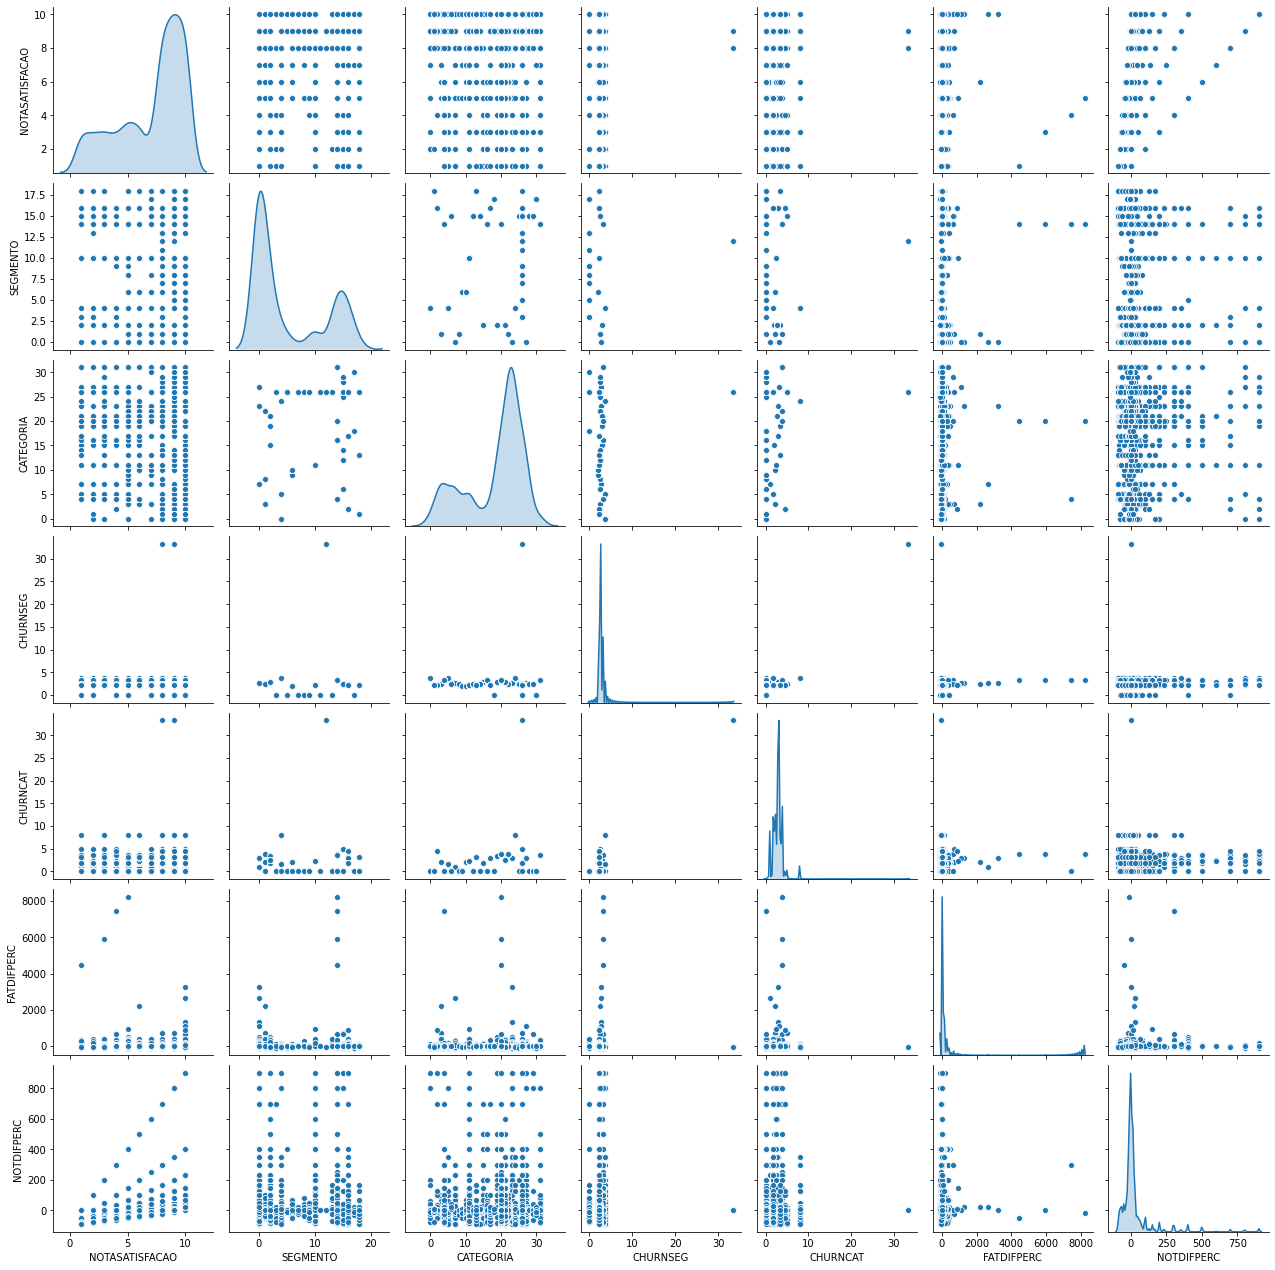

In [0]:
sns.pairplot(notas_numeric[['NOTASATISFACAO','SEGMENTO','CATEGORIA','CHURNSEG','CHURNCAT','FATDIFPERC','NOTDIFPERC']], diag_kind = 'kde')

In [0]:
corr = notas_numeric[['NOTASATISFACAO','SEGMENTO','CATEGORIA','CHURNTOT','CHURNSEG','CHURNCAT','FATDIFPERC','NOTDIFPERC']].corr()

In [0]:
corr

,NOTASATISFACAO,SEGMENTO,CATEGORIA,CHURNTOT,CHURNSEG,CHURNCAT,FATDIFPERC,NOTDIFPERC
NOTASATISFACAO,1.000000e+00,-2.470138e-01,8.551590e-02,6.458694e-15,-1.218040e-01,-7.147525e-02,-2.671003e-02,1.667629e-01
SEGMENTO,-2.470138e-01,1.000000e+00,1.478730e-02,-3.230338e-15,-2.810903e-02,-2.154512e-02,4.264711e-02,5.879968e-02
CATEGORIA,8.551590e-02,1.478730e-02,1.000000e+00,4.990482e-15,-4.410728e-02,3.455943e-01,-1.722144e-02,9.277182e-03
CHURNTOT,6.458694e-15,-3.230338e-15,4.990482e-15,1.000000e+00,-1.084432e-13,3.455250e-15,1.796434e-17,6.576060e-16
CHURNSEG,-1.218040e-01,-2.810903e-02,-4.410728e-02,-1.084432e-13,1.000000e+00,6.127090e-01,1.142206e-02,3.423860e-02
CHURNCAT,-7.147525e-02,-2.154512e-02,3.455943e-01,3.455250e-15,6.127090e-01,1.000000e+00,-1.784951e-03,1.114081e-02
FATDIFPERC,-2.671003e-02,4.264711e-02,-1.722144e-02,1.796434e-17,1.142206e-02,-1.784951e-03,1.000000e+00,1.442579e-02
NOTDIFPERC,1.667629e-01,5.879968e-02,9.277182e-03,6.576060e-16,3.423860e-02,1.114081e-02,1.442579e-02,1.000000e+00


### Comportamento (churn)

In [0]:
%sql
with inicial as (
  select
    MES,
    round(sum(VLVENDA) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as VLVENDA,
    round(sum(QTVENDA) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as QTVENDA,
    round(sum(QTESTABEL) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as QTESTABEL,
    SEGMENTO,
    CATEGORIA,
    round(SUM(FATURAMENTO) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as FATURTOTAL,
    QTCLTOTMES,
    QTCLTOTSEG,
    QTCLTOTCAT,
    CLLOST,
    CLADD,
    CLLOSTSEG,
    CLLOSTCAT,
    CLADDSEG,
    CLADDCAT, 
    CHURNTOT,
    CHURNSEG,
    CHURNCAT,
    row_number() over (partition by MES, SEGMENTO, CATEGORIA order by MES desc) as linha
  from
    dataset_completo
),
segmento as (
  select 
    MES,
    round(sum(VLVENDA) over (partition by MES, SEGMENTO order by MES),2) as VLVENDA,
    round(sum(QTVENDA) over (partition by MES, SEGMENTO order by MES),2) as QTVENDA,
    round(sum(QTESTABEL) over (partition by MES, SEGMENTO order by MES),2) as QTESTABEL,
    SEGMENTO,
    round(SUM(FATURTOTAL) over (partition by MES, SEGMENTO order by MES),2) as FATURTOTAL,
    QTCLTOTMES,
    QTCLTOTSEG,
    CLLOST,
    CLADD,
    CLLOSTSEG,
    CLADDSEG, 
    CHURNTOT,
    CHURNSEG,
    row_number() over (partition by MES, SEGMENTO order by MES desc) as rownumber
  from 
    inicial
  where 
    linha = 1
),
categoria as (
  select 
    MES,
    round(sum(VLVENDA) over (partition by MES, CATEGORIA order by MES),2) as VLVENDA,
    round(sum(QTVENDA) over (partition by MES, CATEGORIA order by MES),2) as QTVENDA,
    round(sum(QTESTABEL) over (partition by MES, CATEGORIA order by MES),2) as QTESTABEL,
    CATEGORIA,
    round(SUM(FATURTOTAL) over (partition by MES, CATEGORIA order by MES),2) as FATURTOTAL,
    QTCLTOTMES,
    QTCLTOTCAT,
    CLLOST,
    CLLOSTCAT,
    CLADD,
    CLADDCAT, 
    CHURNTOT,
    CHURNCAT,
    CHURNSEG,
    row_number() over (partition by MES, CATEGORIA order by MES desc) as rownumber_
  from 
    inicial
  where 
    linha = 1
),
mensal as (
  select 
    MES,
    round(sum(VLVENDA) over (partition by MES order by MES),2) as VLVENDA,
    round(sum(QTVENDA) over (partition by MES order by MES),2) as QTVENDA,
    round(sum(QTESTABEL) over (partition by MES order by MES),2) as QTESTABEL,
    round(SUM(FATURTOTAL) over (partition by MES order by MES),2) as FATURTOTAL,
    QTCLTOTMES,
    CLLOST,
    CLADD,
    CHURNTOT,
    row_number() over (partition by MES order by MES desc) as rownumber__
  from 
    inicial
  where 
    linha = 1
),
mensal_final as (
  select
    MES,
    VLVENDA,
    QTVENDA,
    QTESTABEL,
    FATURTOTAL,
    QTCLTOTMES,
    CLLOST,
    CLADD,
    CHURNTOT
  from
    mensal
  where
    rownumber__ = 1
),
segmento_final as (
  select
    MES,
    VLVENDA,
    QTVENDA,
    QTESTABEL,
    SEGMENTO,
    FATURTOTAL,
    CLLOSTSEG,
    CLADDSEG, 
    CHURNSEG,
    CHURNTOT
  from
    segmento
  where
    rownumber = 1
),
categoria_final as (
  select 
    MES,
    VLVENDA,
    QTVENDA,
    QTESTABEL,
    CATEGORIA,
    FATURTOTAL,
    QTCLTOTCAT,
    CLLOSTCAT,
    CLADDCAT,
    CHURNCAT,
    CHURNSEG,
    CHURNTOT
  from 
    categoria
  where 
    rownumber_ = 1
)
select
  *
from
  mensal_final
order by
  MES

MES,VLVENDA,QTVENDA,QTESTABEL,FATURTOTAL,QTCLTOTMES,CLLOST,CLADD,CHURNTOT
2019-01,1.354617781473E10,82983645,15029,1098044.09,2196,0,2196,0.0
2019-02,1.221538722541E10,79609465,15167,1058120.62,2394,17,215,0.77
2019-03,1.334252026071E10,92058065,15583,1243134.9,2709,21,336,0.88
2019-04,1.311517299799E10,91756192,16483,1259285.92,3414,23,728,0.85
2019-05,1.429338436413E10,100042166,17978,1383408.52,4688,39,1313,1.14
2019-06,1.403850604E10,101614255,18144,1382954.62,4814,82,208,1.75
2019-07,1.518840418902E10,110229767,18166,1455925.62,4776,80,42,1.66
2019-08,1.563692653818E10,112427361,18619,1539652.83,4685,117,26,2.45
2019-09,1.546005915198E10,109549620,18937,1530387.59,4592,119,26,2.54
2019-10,1.605247559088E10,114331679,19129,1577713.86,4507,115,30,2.5


#### Cria os datasets em pandas para a plotagem

In [0]:
def gera_df(option):
  return spark.sql(f"""
  with inicial as (
    select
      MES,
      round(sum(VLVENDA) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as VLVENDA,
      round(sum(QTVENDA) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as QTVENDA,
      round(sum(QTESTABEL) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as QTESTABEL,
      SEGMENTO,
      CATEGORIA,
      round(SUM(FATURAMENTO) over (partition by MES, SEGMENTO, CATEGORIA order by MES),2) as FATURTOTAL,
      QTCLTOTMES,
      QTCLTOTSEG,
      QTCLTOTCAT,
      CLLOST,
      CLADD,
      CLLOSTSEG,
      CLLOSTCAT,
      CLADDSEG,
      CLADDCAT, 
      CHURNTOT,
      CHURNSEG,
      CHURNCAT,
      row_number() over (partition by MES, SEGMENTO, CATEGORIA order by MES desc) as linha
    from
      dataset_completo
  ),
  segmento as (
    select 
      MES,
      round(sum(VLVENDA) over (partition by MES, SEGMENTO order by MES),2) as VLVENDA,
      round(sum(QTVENDA) over (partition by MES, SEGMENTO order by MES),2) as QTVENDA,
      round(sum(QTESTABEL) over (partition by MES, SEGMENTO order by MES),2) as QTESTABEL,
      SEGMENTO,
      round(SUM(FATURTOTAL) over (partition by MES, SEGMENTO order by MES),2) as FATURTOTAL,
      QTCLTOTMES,
      QTCLTOTSEG,
      CLLOST,
      CLADD,
      CLLOSTSEG,
      CLADDSEG, 
      CHURNTOT,
      CHURNSEG,
      row_number() over (partition by MES, SEGMENTO order by MES desc) as rownumber
    from 
      inicial
    where 
      linha = 1
  ),
  categoria as (
    select 
      MES,
      round(sum(VLVENDA) over (partition by MES, CATEGORIA order by MES),2) as VLVENDA,
      round(sum(QTVENDA) over (partition by MES, CATEGORIA order by MES),2) as QTVENDA,
      round(sum(QTESTABEL) over (partition by MES, CATEGORIA order by MES),2) as QTESTABEL,
      CATEGORIA,
      round(SUM(FATURTOTAL) over (partition by MES, CATEGORIA order by MES),2) as FATURTOTAL,
      QTCLTOTMES,
      QTCLTOTCAT,
      CLLOST,
      CLLOSTCAT,
      CLADD,
      CLADDCAT, 
      CHURNTOT,
      CHURNCAT,
      CHURNSEG,
      row_number() over (partition by MES, CATEGORIA order by MES desc) as rownumber_
    from 
      inicial
    where 
      linha = 1
  ),
  mensal as (
    select 
      MES,
      round(sum(VLVENDA) over (partition by MES order by MES),2) as VLVENDA,
      round(sum(QTVENDA) over (partition by MES order by MES),2) as QTVENDA,
      round(sum(QTESTABEL) over (partition by MES order by MES),2) as QTESTABEL,
      round(SUM(FATURTOTAL) over (partition by MES order by MES),2) as FATURTOTAL,
      QTCLTOTMES,
      CLLOST,
      CLADD,
      CHURNTOT,
      row_number() over (partition by MES order by MES desc) as rownumber__
    from 
      inicial
    where 
      linha = 1
  ),
  mensal_final as (
    select
      MES,
      VLVENDA,
      QTVENDA,
      QTESTABEL,
      FATURTOTAL,
      QTCLTOTMES as QtdeClientesMes,
      CLLOST as ClientesPerdidos,
      CLADD as ClientesConquistados,
      CHURNTOT as ChurnTotal
    from
      mensal
    where
      rownumber__ = 1
  ),
  segmento_final as (
    select
      MES,
      VLVENDA,
      QTVENDA,
      QTESTABEL,
      SEGMENTO,
      FATURTOTAL,
      QTCLTOTSEG as QtdeClientesSeg,
      CLLOSTSEG as ClientesPerdSeg,
      CLADDSEG as ClientesConqSeg, 
      CHURNSEG as ChurnSegmento,
      CHURNTOT as ChurnTotal
    from
      segmento
    where
      rownumber = 1
  ),
  categoria_final as (
    select 
      MES,
      VLVENDA,
      QTVENDA,
      QTESTABEL,
      CATEGORIA,
      FATURTOTAL,
      QTCLTOTCAT as QtdeClientesCat,
      CLLOSTCAT as ClientesPerdCat,
      CLADDCAT as ClientesConqCat,
      CHURNCAT as ChurnCategoria,
      CHURNSEG as ChurnSegmento,
      CHURNTOT as ChurnTotal
    from 
      categoria
    where 
      rownumber_ = 1
  )
  select
    *
  from
    {option}
  order by
    MES
  """).toPandas()

In [0]:
mensal_final = gera_df('mensal_final')

In [0]:
segmento_final = gera_df('segmento_final')

In [0]:
categoria_final = gera_df('categoria_final')

### Principais indicadores (totais mensais)

In [0]:
fig = go.Figure()
variaveis = mensal_final.columns.tolist()[1:]

fig.add_trace(go.Bar(x=mensal_final['MES'].unique().tolist(),
                         y=mensal_final[variaveis[0]].tolist(),
                         name=variaveis[0],
                marker_color='indianred')
             )

updatemenu = []
buttons = []

for col in variaveis:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[mensal_final[col].tolist()],
                               'x':[mensal_final['MES'].unique().tolist()],
                               'name':[col],
                               'type':'bar'}, [0]],
                        )
                  )

updatemenu = []
meu_menu = dict()
updatemenu.append(meu_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.show()

### Principais indicadores por segmento (junho/21)

In [0]:
fig = go.Figure()
variaveis = ['VLVENDA','QTVENDA','QTESTABEL','FATURTOTAL','QtdeClientesSeg','ClientesPerdSeg','ClientesConqSeg','ChurnSegmento']

fig.add_trace(go.Bar(x=segmento_final.query("MES=='2021-06'")['SEGMENTO'].unique().tolist(),
                         y=segmento_final.query("MES=='2021-06'")[variaveis[0]].tolist(),
                         name=variaveis[0],
                marker_color='rgb(55, 83, 108)')
             )

updatemenu = []
buttons = []

for col in variaveis:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[segmento_final.query("MES=='2021-06'")[col].tolist()],
                               'x':[segmento_final.query("MES=='2021-06'")['SEGMENTO'].unique().tolist()],
                               'name':[col],
                               'type':'bar'}, [0]],
                        )
                  )

updatemenu = []
meu_menu = dict()
updatemenu.append(meu_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.show()